In [17]:
import torch as th 
from torch.nn import MSELoss
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from model import Generator, Discriminator, gradient_penalty, polygon_penalty
from utils import Transformed_PolyGraphDataset, CATEGORY_DICT

import numpy as np
import time 

# Hyperparameters


In [18]:
""" 
Hyperparameters
"""

MAX_POLYGONS = 30       # max nr. of polygons to output

# Optimizer params
g_lr = 0.001 
d_lr = 0.001
b1 = 0.5 
b2 = 0.999  

# WGAN params
N_critic = 5            # nr of times to train discriminator more
lambda_gp = 10          # gradient penalty hyperpraram

# Training params
MAX_EPOCHS = 50
BATCH_SIZE = 32

# Network parameters
NOISE_SIZE = 128
HIDDEN_GENERATOR = [64, 32, 32]                 # list of dimensions for hidden layers
OUTPUT_GENERATOR = MAX_POLYGONS * 2             # we want to output at most this many polygons per node (note [x1... y1...] format)

HIDDEN_DISCRIMINATOR = [64, 32, 16]

# Model definition

### Generator
- Input of Generator will always be: "noise size + Nr. of categories" 
- Output of Generator = (MAX_POYLGONS * 2) due to our output coordinate format


### Discriminator
- Input of Discriminator = output of Generator (MAX_POLYGONS * 2) due to our output coordinate format
- Output of Discriminator will always be 1

In [19]:
""" 
Model Definitions
"""
generator = Generator(input_dim=NOISE_SIZE + len(CATEGORY_DICT), 
                      output_dim=OUTPUT_GENERATOR, 
                      hidden_dims=HIDDEN_GENERATOR)

discriminator = Discriminator(input_dim=OUTPUT_GENERATOR, 
                              hidden_dims=HIDDEN_DISCRIMINATOR)

print(generator.module_list)
print(discriminator.module_list)

ModuleList(
  (0): TAGConv(141, 64, K=3)
  (1): TAGConv(64, 32, K=3)
  (2): TAGConv(32, 60, K=3)
)
ModuleList(
  (0): TAGConv(60, 64, K=3)
  (1): TAGConv(64, 32, K=3)
  (2): TAGConv(32, 16, K=3)
  (3): Linear(in_features=16, out_features=1, bias=True)
)


In [20]:
# Optimizers
optimizer_G = th.optim.Adam(generator.parameters(), lr=g_lr, betas=(b1, b2)) 
optimizer_D = th.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(b1, b2))

# Loss instantiation
mse_loss = MSELoss()

# Training loop

Generator details:
- We generate a noise vector
- Generator uses noise vector and training data (the categories) as input
- Generator uses graph NN layers to generate coordinates out of the noise vectors using the graph structure and categories
- Generator output: (MAX_POLYGONS * 2) for each node in the input

Discriminator details:
- Generate discriminator output (score) for real data and fake (generated) data
- Compute loss over these scores with additional gradient penalty loss

In [24]:
def run_epoch(generator, discriminator, optimizer_g, optimizer_d, data_loader):

    losses_g, losses_d = [], []
    num_steps = 0

    # real = batch of Data() ex. [Data(), Data(), ...] is 1 batch
    start_time = time.time()
    for i, real in enumerate(data_loader):
        num_steps += 1

        # Input noise_data into generator            
        noise = th.randn((len(real.category), NOISE_SIZE))
        fake = generator(real, noise)     

        # fake.shape = (batch_size * nodes, output_features = 60)
        # We must turn this into appropriate (batch) input for the discriminator
        fake = Batch(geometry=fake, edge_index=real.edge_index, batch=real.batch)

        discriminator_fake = discriminator(fake)    # discriminator scores for fakes
        discriminator_real = discriminator(real)    # discriminator scores for reals
        
        gp = gradient_penalty(discriminator, real, fake)

        # Discriminator loss and train
        loss_discriminator = -(th.mean(discriminator_real) - th.mean(discriminator_fake)) + lambda_gp * gp
        
        discriminator.zero_grad() 
        loss_discriminator.backward() 
        optimizer_d.step()

        losses_d.append(loss_discriminator.item())

        # Only train Generator every 5 steps
        if num_steps % N_critic == 0:
            noise_g = th.randn((len(real.category), NOISE_SIZE))
            fake_g = generator(real, noise_g) 
            fake_g = Batch(geometry=fake_g, edge_index=real.edge_index, batch=real.batch)

            output = discriminator(fake_g).reshape(-1)      # discriminator scores for fake
            # loss for genereator = the discriminators' judgement
            # higher score = better so lower loss
            loss_generator = -th.mean(output) + mse_loss(real.geometry, fake_g.geometry)
            generator.zero_grad()
            loss_generator.backward()
            optimizer_g.step()

            losses_g.append(loss_generator.item())
        
        # 49 is just a temporary number
        if i % 50 == 0:
            batch_time = time.time() - start_time
            print("Batch {} took {:.2f} seconds.".format(i, batch_time))
    
    return sum(losses_g) / len(losses_g), sum(losses_d) / len(losses_d)

# Main training loop

Code could be improved. Make sure to specify your own 'generator_path', 'discriminator_path'.

In [27]:
# Main training loop
def train(generator, discriminator, optimizer_g, optimizer_d, data_loader, max_epochs):
    start_time = time.time() 
    losses_g, losses_d = [], []

    for epoch in range(1, max_epochs + 1):
        epoch_time = time.time() 

        loss_g, loss_d = run_epoch(generator, discriminator, optimizer_g, optimizer_d, data_loader)
        losses_g.append(loss_g)
        losses_d.append(loss_d)

        # TODO: Evaluation and logging code??
        epoch_time = time.time() - epoch_time 
        total_time = time.time() - start_time
        print("Total runtime: {:.2f}, Epoch: {}, took: {:.2f} seconds, loss_g: {:.2f}, loss_d: {:.2f}".format(total_time, epoch, epoch_time, loss_g, loss_d))

        # save model every 10 epochs
        if epoch % 10:
            print("Saving model at epoch {}".format(epoch))
            generator_path = r'C:\School\DELFT\Graph_ML_project\saved_models\generator.pt'
            discriminator_path = r'C:\School\DELFT\Graph_ML_project\saved_models\discriminator.pt'
            th.save(generator.state_dict(), generator_path)
            th.save(discriminator.state_dict(), discriminator_path)

    return losses_g, losses_d

# Training code

In [28]:
path = r'C:\School\DELFT\Graph_ML_project\data\swiss-dwellings-v3.0.0'
dataset = Transformed_PolyGraphDataset(path)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
n_batches = len(dataloader)
print(n_batches)

losses_g, losses_d = train(generator, discriminator, optimizer_G, optimizer_D, dataloader, max_epochs=20)

294
Batch 0 took 0.17 seconds.
Batch 50 took 9.83 seconds.
Batch 100 took 19.40 seconds.
Batch 150 took 28.67 seconds.
Batch 200 took 37.88 seconds.
Batch 250 took 47.29 seconds.
Total runtime: 55.95, Epoch: 1, took: 55.95 seconds, loss_g: -441.47, loss_d: -1973.15
Saving model at epoch 1
Batch 0 took 0.20 seconds.
Batch 50 took 10.84 seconds.
Batch 100 took 22.06 seconds.
Batch 150 took 31.74 seconds.
Batch 200 took 41.14 seconds.
Batch 250 took 51.06 seconds.
Total runtime: 115.54, Epoch: 2, took: 59.57 seconds, loss_g: -110.30, loss_d: -1647.77
Saving model at epoch 2
Batch 0 took 0.21 seconds.
Batch 50 took 9.79 seconds.
Batch 100 took 19.94 seconds.
Batch 150 took 29.83 seconds.
Batch 200 took 39.44 seconds.
Batch 250 took 49.19 seconds.
Total runtime: 172.84, Epoch: 3, took: 57.30 seconds, loss_g: -327.57, loss_d: -1719.19
Saving model at epoch 3
Batch 0 took 0.17 seconds.
Batch 50 took 9.79 seconds.
Batch 100 took 19.56 seconds.
Batch 150 took 29.81 seconds.
Batch 200 took 39.34

# Generator output code

The following section contains code to generate the coordinates for a floorplan using the generator.

requires:
- graph 
- categories per node (room)
- noise vector (of size: NOISE_SIZE)

In [29]:
# Load model
model_g_path = r'C:\School\DELFT\Graph_ML_project\saved_models\generator.pt'

# Make sure the model you're loading in is consistent with the size of your model
generator = Generator(input_dim=NOISE_SIZE + len(CATEGORY_DICT), 
                      output_dim=OUTPUT_GENERATOR, 
                      hidden_dims=HIDDEN_GENERATOR)

generator.load_state_dict(th.load(model_g_path))
print(generator)

Generator(
  (module_list): ModuleList(
    (0): TAGConv(141, 64, K=3)
    (1): TAGConv(64, 32, K=3)
    (2): TAGConv(32, 60, K=3)
  )
)


In [67]:
# Generate floorplan
path = r'C:\School\DELFT\Graph_ML_project\data\swiss-dwellings-v3.0.0'
dataset = Transformed_PolyGraphDataset(path)

data = dataset[0]
print(data)
print(data.geometry[0])

noise_vector = th.randn((data.num_nodes, NOISE_SIZE))
output = generator(data, noise_vector)
print(output.shape)

output_data = Data(edge_index=data.edge_index, geometry=output, category=data.category, num_nodes=data.num_nodes)
print(output_data)

Data(edge_index=[2, 72], geometry=[42, 60], category=[42, 13], num_nodes=42)
tensor([4.6750, 3.1847, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 2.2827, 2.8058, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([42, 60])
Data(edge_index=[2, 72], geometry=[42, 60], category=[42, 13], num_nodes=42)


# Visualuze floorplan

Work in progres...

In [31]:
import numpy as np
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import networkx as nx

FS = 10
SUBTYPES_NAMES = [
     'Remaining',
     'Bathroom',
     'Kitchen-Dining',
     'Bedroom',
     'Corridor',
     'Stairs-Ramp',
     'Outdoor-Area',
     'Living-Room',
     'Basement',
     'Office',
     'Garage',
     'Warehouse-Logistics',
     'Meeting-Salesroom'
]

def plot_polygon(ax, poly, **kwargs):
    x, y = poly[:MAX_POLYGONS], poly[MAX_POLYGONS:]
    ax.fill(x, y, **kwargs)
    return

def plot_floorplan(ax, areas, area_types, doors=False, walls=False, classes=SUBTYPES_NAMES, colorset='tab20', **kwargs):

    cmap = get_cmap(colorset)

    for area, area_type in zip(areas, area_types):
        try:
            np.isnan(area_type)
            color_index = len(classes) + 1
        except:
            color_index = classes.index(area_type)
        c=np.array(cmap(color_index)).reshape(1,4)
        plot_polygon(ax, area, fc=c, ec=c, label=c, **kwargs)

    if walls:
        for wall in walls:
            plot_polygon(ax, wall, fc='#72246c', ec='#72246c', **kwargs)
    if doors:
        for door in doors[0]:
            plot_polygon(ax, door, fc='red', ec='red', **kwargs)

        for door in doors[1]:
            plot_polygon(ax, door, fc='orange', ec='orange', **kwargs)

In [63]:
def filter_polygons(geometries, const=0.5):
    polygons = []
    for g in geometries:
        g[th.abs(g) < const] = 0
        xs = g[:MAX_POLYGONS]
        ys = g[MAX_POLYGONS:]

        current_poly = []
        for x, y in zip(xs, ys):
            if x != 0 or y != 0:
                current_poly.append((x.item(), y.item()))
        
        polygons.append(current_poly)

    return polygons

tensor([3, 0, 1, 3, 1, 2, 3, 7, 4, 4, 3, 3, 4, 2, 0, 1, 3, 1, 0, 0, 2, 7, 4, 3,
        3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5])
[[(-3.71614670753479, -3.7492172718048096), (0.0, 0.5514585375785828)], [(-15.176667213439941, -15.140957832336426), (5.632940769195557, 5.0686821937561035), (0.0, 0.7534084916114807), (0.70332270860672, 0.5360590219497681), (0.0, -0.5997366905212402), (-0.5675117373466492, 0.0), (1.358695149421692, 0.0), (0.0, 0.5821052193641663), (0.7464379668235779, 0.0), (-0.5926871299743652, 0.7796998023986816), (0.0, 1.8168654441833496), (0.0, -0.9096238613128662), (-0.7175177931785583, 0.0), (0.8363728523254395, 0.849921464920044), (0.0, 0.543422281742096), (0.0, -0.5956943035125732), (0.0, -0.8573947548866272), (0.0, -0.6276554465293884), (0.0, 1.6994669437408447), (0.0, -0.9461386203765869), (-0.8987258672714233, 0.0), (0.0, 1.1647921800613403)], [(-11.09818172454834, -11.22506046295166), (2.784661054611206, 2.0929365158081055), (0.0, -0.553301513195037

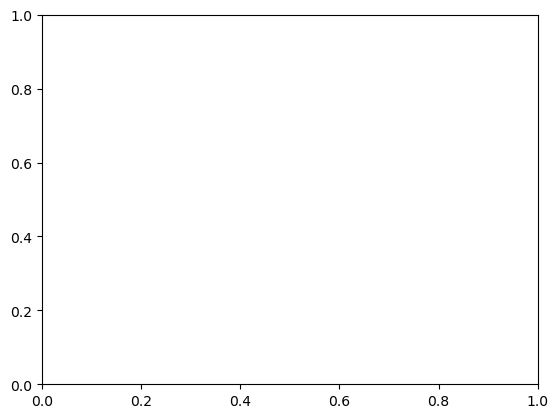

In [64]:
# Visualize floorplan
# use output_data = Data(edge_index, geometry, category, num_nodes)
categories = output_data.category.argmax(dim=-1)
print(categories)

fig, ax = plt.subplots()
filtered_polygons = filter_polygons(output_data.geometry.detach())
print(filtered_polygons)
# filtered_polygons = output_data.geometry.detach()
#plot_floorplan(ax, filtered_polygons, categories.detach().numpy())

In [61]:
print(output_data.geometry[:5])

tensor([[ -3.7161,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,  -3.7492,   0.0000,   0.0000,   0.0000,   0.0000,
           0.5515,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000],
        [-15.1767,   5.6329,   0.0000,   0.0000,   0.7033,   0.0000,   0.0000,
          -0.5675,   1.3587,   0.0000,   0.0000,   0.0000,   0.0000,   0.7464,
          -0.5927,   0.0000,   0.0000,  -0.7175,   0.8364,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.8987,   0.0000,
  